# Model Training

Author: Alex Lim

This notebook runs through a typical pipeline of training models and saves models to file for later observation.?


## Hardware Information

In [14]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8039354282513047573, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15617977488743352116
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4564451328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 737808822361902963
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:04:00.0, compute capability: 6.1", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9133435576043501862
 physical_device_desc: "device: XLA_GPU device"]

## Import Packages

In [21]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import cv2
import glob
import time
import math
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

# Import models and config
import config
from models import vanilla, vgg16, mobilenetv2, inceptionv3

# Set random seed for consistency
random.seed(100)
np.random.seed(100)
tf.set_random_seed(100)

# Displays all outputs of a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 5]

print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

TensorFlow version: 1.14.0
Keras version: 2.2.4-tf


In [36]:
work_dir = '.'
data_dir = os.path.join(work_dir, 'data')

# Original data (before split)
black_measles_dir = os.path.join(data_dir, 'black_measles')
black_rot_dir = os.path.join(data_dir, 'black_rot')
leaf_blight_dir = os.path.join(data_dir, 'leaf_blight')
healthy_dir = os.path.join(data_dir, 'healthy')

# Train/Validation/Test
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Training data by class
train_black_measles_dir = os.path.join(train_dir, 'black_measles')
train_black_rot_dir = os.path.join(train_dir, 'black_rot')
train_leaf_blight_dir = os.path.join(train_dir, 'leaf_blight')
train_healthy_dir = os.path.join(train_dir, 'healthy')

# Validation data by class
validation_black_measles_dir = os.path.join(validation_dir, 'black_measles')
validation_black_rot_dir = os.path.join(validation_dir, 'black_rot')
validation_leaf_blight_dir = os.path.join(validation_dir, 'leaf_blight')
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# Test data by class
test_black_measles_dir = os.path.join(test_dir, 'black_measles')
test_black_rot_dir = os.path.join(test_dir, 'black_rot')
test_leaf_blight_dir = os.path.join(test_dir, 'leaf_blight')
test_healthy_dir = os.path.join(test_dir, 'healthy')

In [4]:
num_black_measles = len(os.listdir(black_measles_dir))
num_black_rot = len(os.listdir(black_rot_dir))
num_leaf_blight = len(os.listdir(leaf_blight_dir))
num_healthy = len(os.listdir(healthy_dir))
total_images = num_black_measles + num_black_rot + num_leaf_blight + num_healthy
                                   
print('Total Images: {}'.format(total_images))
print('black_measles class has {} images'.format(num_black_measles))
print('black_rot class has {} images'.format(num_black_rot))
print('leaf_blight class has {} images'.format(num_leaf_blight))
print('healthy class has {} images'.format(num_healthy))

Total Images: 4062
black_measles class has 1383 images
black_rot class has 1180 images
leaf_blight class has 1076 images
healthy class has 423 images


In [5]:
pct_black_measles = (num_black_measles / total_images) * 100.0
pct_black_rot = (num_black_rot / total_images) * 100.0
pct_leaf_blight = (num_leaf_blight / total_images) * 100.0
pct_healthy = (num_healthy / total_images) * 100.0

print('Percentage of black_measles class: {:.2f}%'.format(pct_black_measles))
print('Percentage of black_rot class: {:.2f}%'.format(pct_black_rot))
print('Percentage of leaf_blight class: {:.2f}%'.format(pct_leaf_blight))
print('Percentage of healthy class: {:.2f}%'.format(pct_healthy))

Percentage of black_measles class: 34.05%
Percentage of black_rot class: 29.05%
Percentage of leaf_blight class: 26.49%
Percentage of healthy class: 10.41%


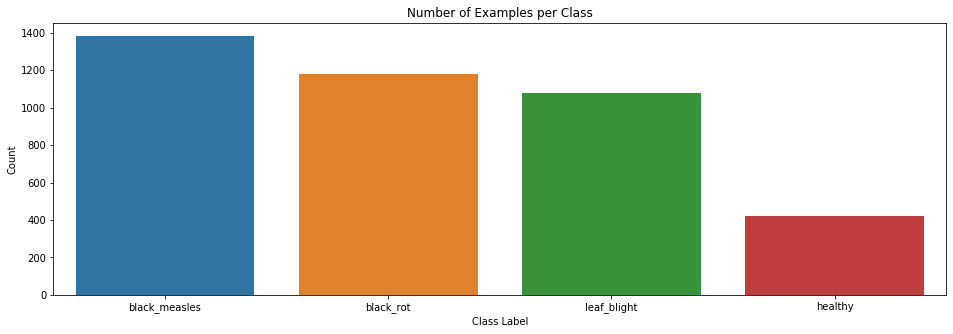

In [6]:
data_dist = pd.DataFrame.from_dict(data={ 'black_measles': [num_black_measles],
                                          'black_rot': [num_black_rot],
                                          'leaf_blight': [num_leaf_blight],
                                          'healthy': [num_healthy] } )
sns.barplot(data=data_dist);
plt.xlabel('Class Label');
plt.ylabel('Count');
plt.title('Number of Examples per Class');

In [7]:
# Sanity check 
num_train_black_measles = len(os.listdir(train_black_measles_dir))
num_train_black_rot = len(os.listdir(train_black_rot_dir))
num_train_leaf_blight = len(os.listdir(train_leaf_blight_dir))
num_train_healthy = len(os.listdir(train_healthy_dir))

num_val_black_measles = len(os.listdir(validation_black_measles_dir))
num_val_black_rot = len(os.listdir(validation_black_rot_dir))
num_val_leaf_blight = len(os.listdir(validation_leaf_blight_dir))
num_val_healthy = len(os.listdir(validation_healthy_dir))

num_test_black_measles = len(os.listdir(test_black_measles_dir))
num_test_black_rot = len(os.listdir(test_black_rot_dir))
num_test_leaf_blight = len(os.listdir(test_leaf_blight_dir))
num_test_healthy = len(os.listdir(test_healthy_dir))

total_train = num_train_black_measles + num_train_black_rot + \
                num_train_leaf_blight + num_train_healthy
total_val = num_val_black_measles + num_val_black_rot + \
              num_val_leaf_blight + num_val_healthy
total_test = num_test_black_measles + num_test_black_rot + \
              num_test_leaf_blight + num_test_healthy

def check_distribution(total, black_measles, black_rot, leaf_blight, healthy):
  print('% of black_measles: {:.2f}%'.format((black_measles/total)*100.0))
  print('% of blacK_rot: {:.2f}%'.format((black_rot / total)*100))
  print('% of leaf_blight: {:.2f}%'.format((leaf_blight / total)*100.0))
  print('% of healthy: {:.2f}%'.format((healthy / total)*100.0))
  print()
  
print('Total images:', total_train + total_val + total_test)
print('Total black_measles:', num_train_black_measles+num_val_black_measles+num_test_black_measles)
print('Total blacK_rot:', num_train_black_rot+num_val_black_rot+num_test_black_rot)
print('Total leaf_blight:', num_train_leaf_blight+num_val_leaf_blight+num_test_leaf_blight)
print('Total healthy:', num_train_healthy+num_val_healthy+num_test_healthy)
print()
print('Number of black_measles training images:', num_train_black_measles)
print('Number of black_rot training images:', num_train_black_rot)
print('Number of leaf_blight training images:', num_train_leaf_blight)
print('Number of healthy training images:', num_train_healthy)
print()
print('Number of black_measles validation images:', num_val_black_measles)
print('Number of black_rot validation images:', num_val_black_rot)
print('Number of leaf_blight validation images:', num_val_leaf_blight)
print('Number of healthy validation images:', num_val_healthy)
print()
print('Number of black_measles test images:', num_test_black_measles)
print('Number of black_rot test images:', num_test_black_rot)
print('Number of leaf_blight test images:', num_test_leaf_blight)
print('Number of healthy test images:', num_test_healthy)
print()
print('Training distribution')
check_distribution(total_train, num_train_black_measles, num_train_black_rot,
                    num_train_leaf_blight, num_train_healthy)
print('Validation distribution')
check_distribution(total_val, num_val_black_measles, num_val_black_rot,
                    num_val_leaf_blight, num_val_healthy)
print('Test distribution')
check_distribution(total_test, num_test_black_measles, num_test_black_rot,
                    num_test_leaf_blight, num_test_healthy)

Total images: 4062
Total black_measles: 1383
Total blacK_rot: 1180
Total leaf_blight: 1076
Total healthy: 423

Number of black_measles training images: 886
Number of black_rot training images: 756
Number of leaf_blight training images: 689
Number of healthy training images: 272

Number of black_measles validation images: 221
Number of black_rot validation images: 188
Number of leaf_blight validation images: 172
Number of healthy validation images: 67

Number of black_measles test images: 276
Number of black_rot test images: 236
Number of leaf_blight test images: 215
Number of healthy test images: 84

Training distribution
% of black_measles: 34.04%
% of blacK_rot: 29.04%
% of leaf_blight: 26.47%
% of healthy: 10.45%

Validation distribution
% of black_measles: 34.10%
% of blacK_rot: 29.01%
% of leaf_blight: 26.54%
% of healthy: 10.34%

Test distribution
% of black_measles: 34.03%
% of blacK_rot: 29.10%
% of leaf_blight: 26.51%
% of healthy: 10.36%



## ImageDataGenerators

In [22]:
print('Total number of training examples:', total_train)
print('Total number of validation examples:', total_val)
print('Total number of test examples:', total_test)

Total number of training examples: 2603
Total number of validation examples: 648
Total number of test examples: 811


In [23]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(config.img_height, config.img_width),
                    color_mode='rgb',
                    batch_size=config.batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=42)

validation_generator = test_datagen.flow_from_directory(
                          validation_dir,
                          target_size=(config.img_height, config.img_width),
                          color_mode='rgb',
                          batch_size=config.batch_size,
                          class_mode='categorical')

valtest_generator = test_datagen.flow_from_directory(
                          validation_dir,
                          target_size=(config.img_height, config.img_width),
                          color_mode='rgb',
                          batch_size=1,
                          class_mode='categorical')

# Test data generator - no augmentation (to be used at very end)
test_gen = test_datagen.flow_from_directory(
                test_dir,
                target_size=(config.img_height, config.img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 2603 images belonging to 4 classes.
Found 648 images belonging to 4 classes.
Found 648 images belonging to 4 classes.
Found 811 images belonging to 4 classes.


In [24]:
# Output of Dataset should give a dict 
# {'train': train, 'num_train', num_train, ...}

data = {'train': train_generator,
        'num_train': total_train,
        'val': validation_generator,
        'num_val': total_val,
        'test': test_gen,
        'num_test': total_test,
        'valtest': test_gen}

## Training

Section for model training. To adjust hyperparameters, modify config/__init__.py file.

In [33]:
if not os.path.exists('./trained_models'):
    os.makedirs('./trained_models')

### Vanilla CNN

In [25]:
model = vanilla.VanillaCNN()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0   

In [27]:
# Train vanilla CNN model
model.train(data)

# Save model
name = 'vanillaCNN_model_epochs30'
model.save('./trained_models/{}'.format(name))

### VGG16 Model

In [28]:
model = vgg16.VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Train VGG16 model
model.train(data)

# Save model
name = 'vgg16_model_epochs30'
model.save('./trained_models/{}'.format(name))

### MobileNetV2 Model

In [29]:
model = mobilenetv2.MobileNetV2()
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_3 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8028288   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 516       
Total params: 10,286,788
Trainable params: 8,028,804
Non-trainable params: 2,257,984
________________________________________

In [ ]:
# Train MobileNetV2 model
model.train(data)

# Save model
name = 'mobilenetv2_model_epochs30'
model.save('./trained_models/{}'.format(name))

### InceptionV3 Model

In [31]:
model = inceptionv3.InceptionV3()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1028      
Total params: 34,911,268
Trainable params: 13,108,484
Non-trainable params: 21,802,784
______________________________________

In [ ]:
# Train InceptionV3 model
model.train(data)

# Save model
name = 'inceptionv3_model_epochs30'
model.save('./trained_models/{}'.format(name))